In [861]:
!pip install pandas
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\jpedr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\jpedr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\jpedr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\jpedr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\jpedr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\jpedr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [885]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Objetivo: importar bibliotecas essenciais para análise, visualização e normalização dos dados.


In [863]:
column_names = ['Sex', 'Length', 'Diameter', 'Height', 
                'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 
                'ShellWeight', 'Rings']

df = pd.read_csv("abalone.data", header=None, names=column_names)

# Carregamos o arquivo `abalone.data` com nomes de colunas definidos manualmente

In [864]:
df.head()


,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [865]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4177 non-null   object 
 1   Length         4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [866]:
df.describe()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [867]:
df.isnull().sum()

# Confirmamos que não há valores nulos no dataset (como esperado)


Sex              0
Length           0
Diameter         0
Height           0
WholeWeight      0
ShuckedWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64

Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


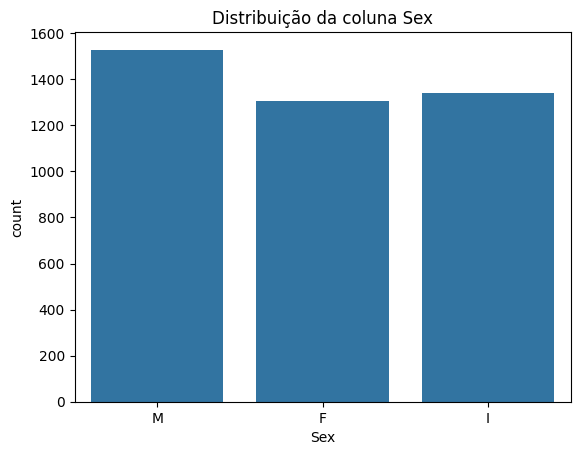

In [868]:
print(df['Sex'].value_counts())

sns.countplot(x='Sex', data=df)
plt.title('Distribuição da coluna Sex')
plt.show()

# Útil para visualizar distribuição das categorias M, F e I (infant)


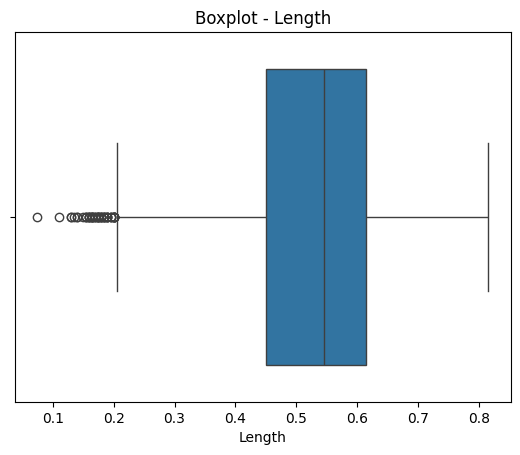

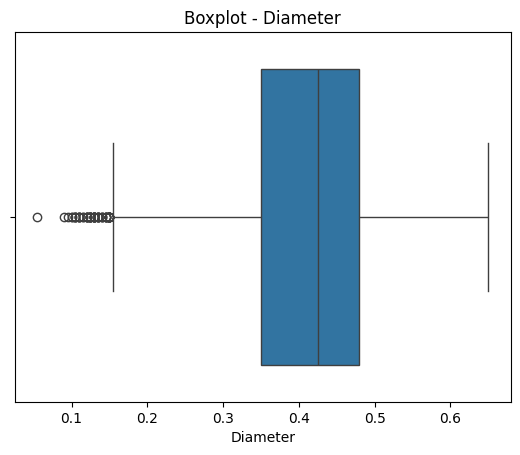

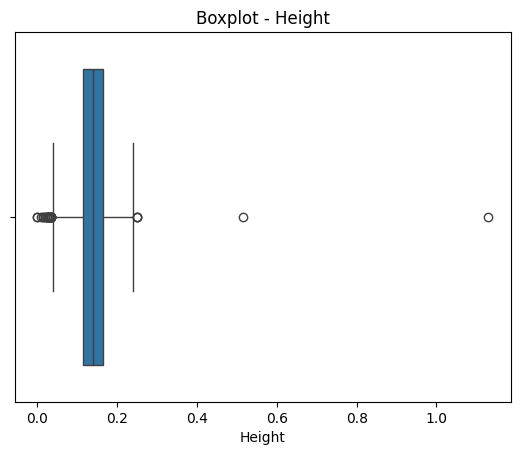

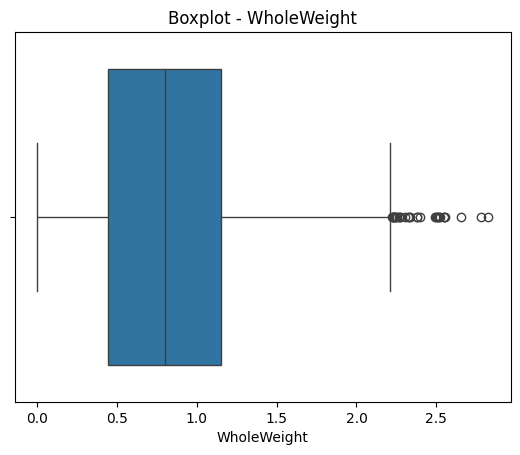

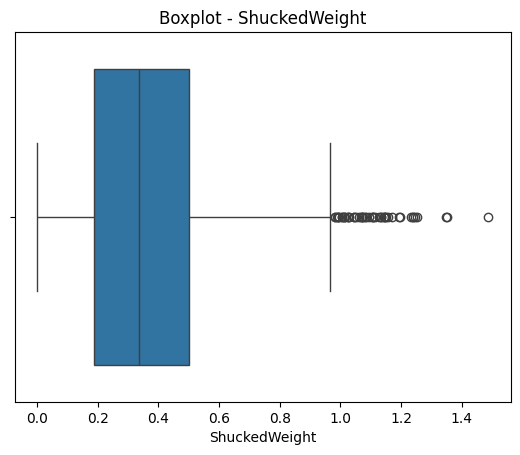

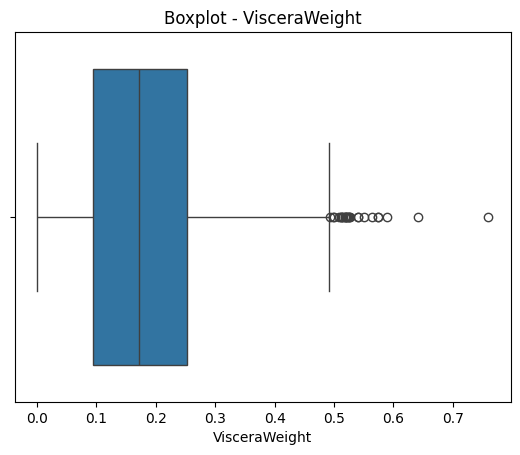

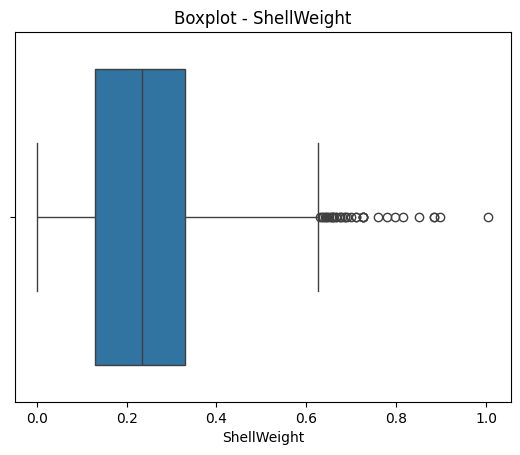

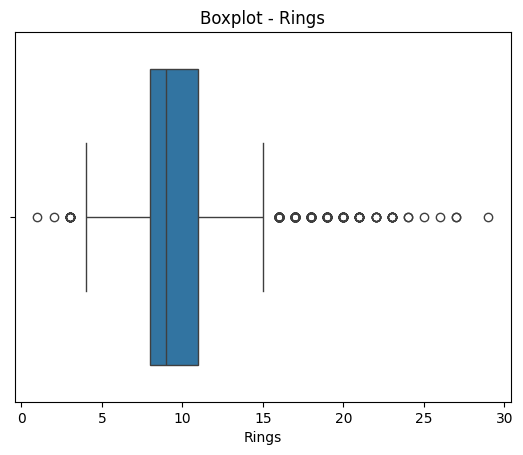

In [869]:
num_features = df.columns[1:]  # excluindo 'Sex'

for col in num_features:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot - {col}')
    plt.show()


In [870]:
df_clean = df.copy()

numeric_features = ['Length', 'Diameter', 'Height', 
                'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 
                'ShellWeight',]
categorical_features = ['Sex']




In [ ]:
def remove_outliers_iqr_corrigido(df, columns):
    df_out = df.copy()

    limites = {}
    for col in columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        limites[col] = (limite_inferior, limite_superior)

    # Uma linha é mantida se TODOS os seus valores estiverem dentro dos respectivos limites.
    mascara_outliers = pd.Series([True] * len(df_out), index=df_out.index)
    for col in columns:
        lim_inf, lim_sup = limites[col]
        mascara_outliers &= (df_out[col] >= lim_inf) & (df_out[col] <= lim_sup)

    return df_out[mascara_outliers]

print(f"Tamanho original do DataFrame: {df.shape}")
df_clean = remove_outliers_iqr_corrigido(df_clean, numeric_features)
print(f"Tamanho do DataFrame após remoção de outliers: {df_clean.shape}")

Tamanho original do DataFrame: (4177, 9)
Tamanho do DataFrame após remoção de outliers: (4024, 9)


In [872]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
)

df_for_transforming = df_clean[numeric_features+categorical_features]

X_processed = preprocessor.fit_transform(df_for_transforming)

new_columns = preprocessor.get_feature_names_out()

df_processed_scaled = pd.DataFrame(X_processed, columns=new_columns)

new_columns_with_prefix = preprocessor.get_feature_names_out()

cleaned_columns = [col.split('__')[1] for col in new_columns_with_prefix]

df_processed_scaled = pd.DataFrame(X_processed, columns=cleaned_columns)

df_processed_scaled.head()


,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Sex_F,Sex_I,Sex_M
0,-0.632245,-0.474574,-1.23997,-0.666150,-0.631483,-0.753592,-0.665126,0.0,0.0,1.0
1,-1.580579,-1.562434,-1.38003,-1.310363,-1.251442,-1.270933,-1.296032,0.0,0.0,1.0
2,0.045136,0.123750,-0.11949,-0.302174,-0.472773,-0.354500,-0.191946,1.0,0.0,0.0
3,-0.767721,-0.474574,-0.39961,-0.661684,-0.676120,-0.625488,-0.625694,0.0,0.0,1.0
4,-1.761214,-1.671220,-1.66015,-1.356139,-1.301038,-1.359620,-1.414327,0.0,1.0,0.0


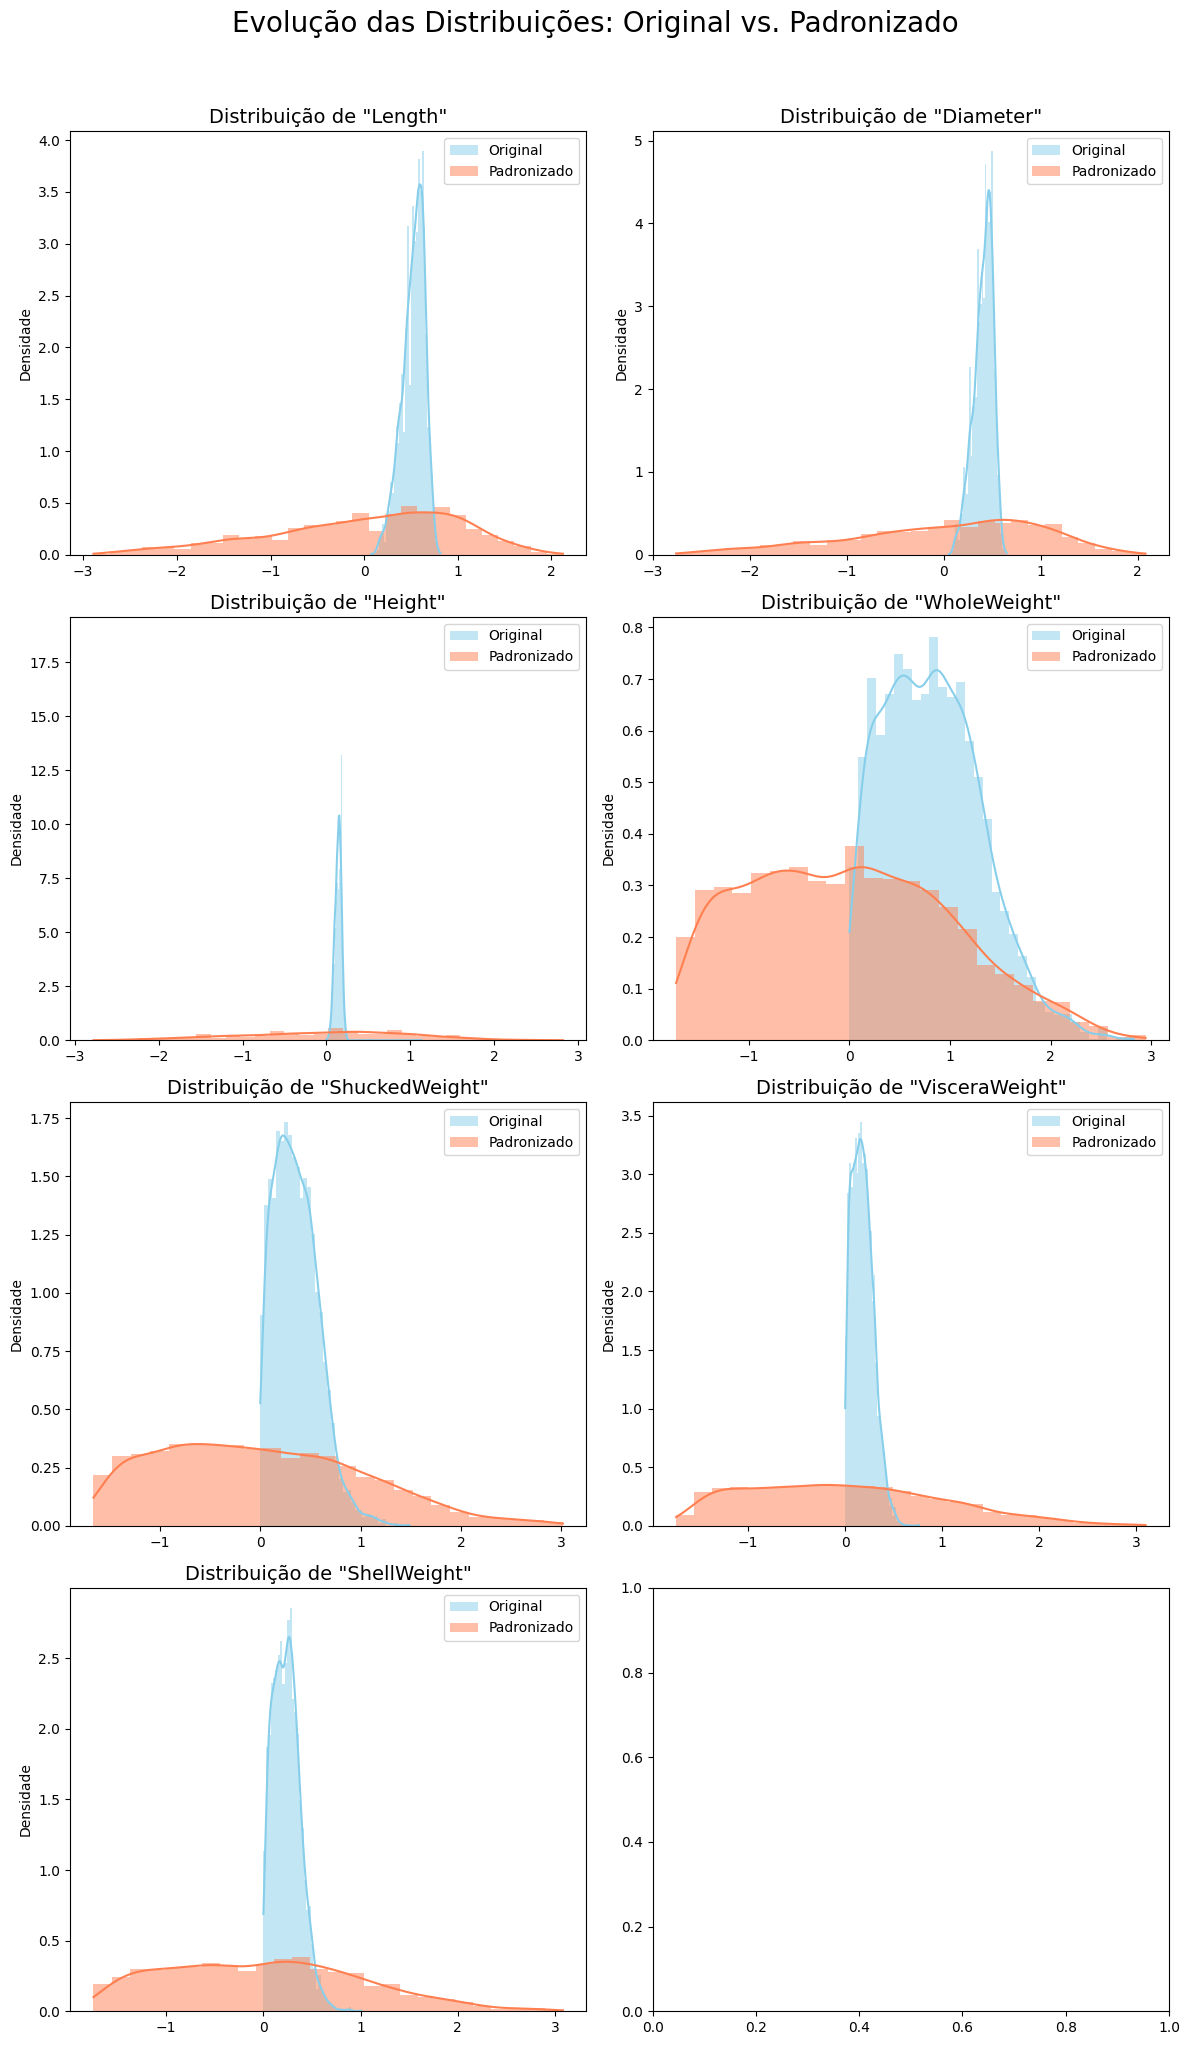

In [873]:
n_features = len(numeric_features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    ax = axes[i]
    sns.histplot(data=df, x=feature, color="skyblue", label='Original', kde=True, ax=ax, stat="density", linewidth=0)
    sns.histplot(data=df_processed_scaled, x=feature, color="coral", label='Padronizado', kde=True, ax=ax, stat="density", linewidth=0)
    ax.set_title(f'Distribuição de "{feature}"', fontsize=14)
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('Densidade')

fig.suptitle('Evolução das Distribuições: Original vs. Padronizado', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

C:\Users\jpedr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


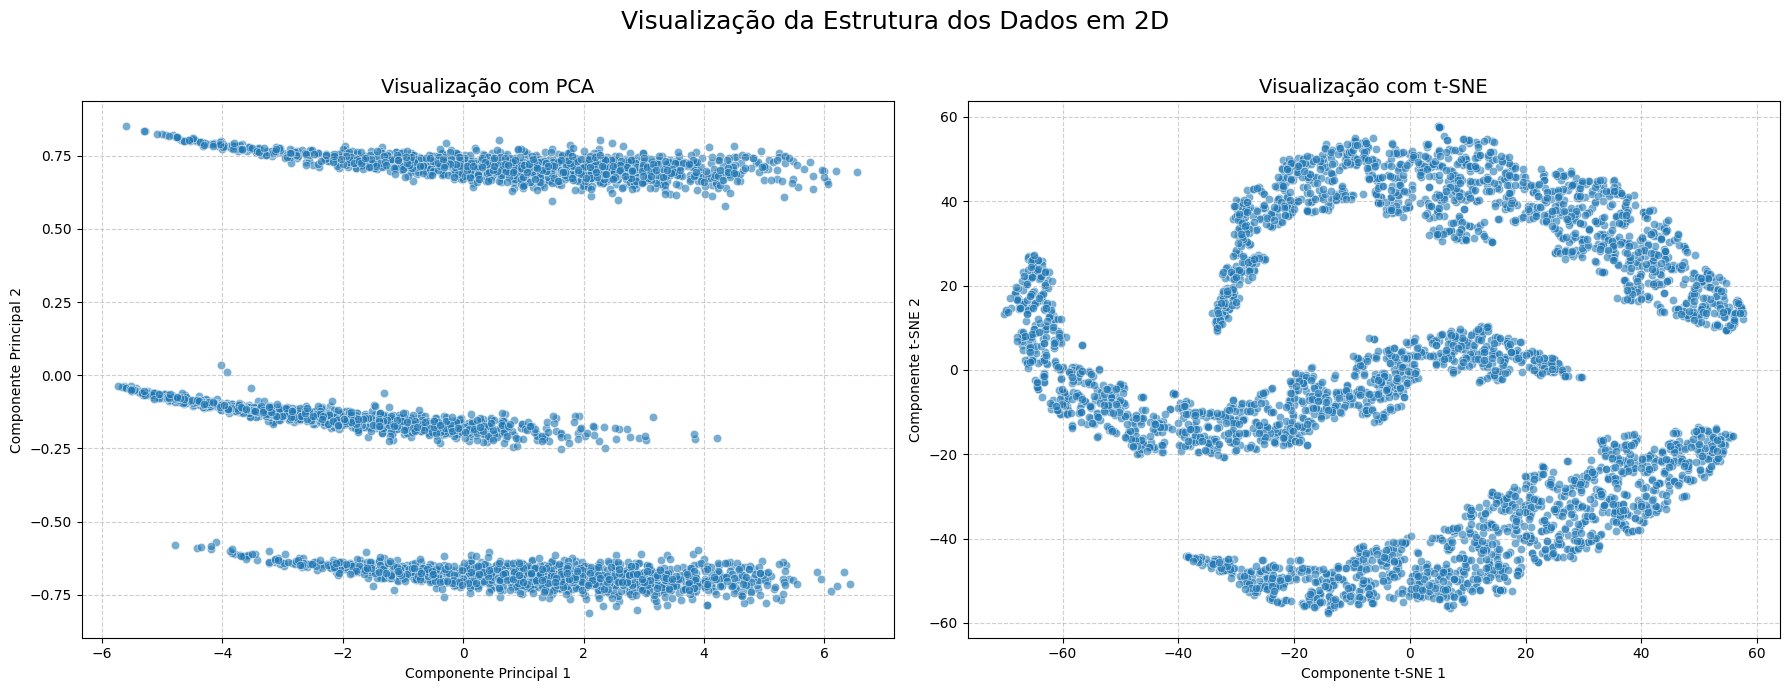

In [874]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_processed_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(df_processed_scaled)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

fig.suptitle('Visualização da Estrutura dos Dados em 2D', fontsize=18)

#PCA
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], ax=axes[0], alpha=0.6)
axes[0].set_title('Visualização com PCA', fontsize=14)
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')
axes[0].grid(True, linestyle='--', alpha=0.6)

#t-SNE
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], ax=axes[1], alpha=0.6)
axes[1].set_title('Visualização com t-SNE', fontsize=14)
axes[1].set_xlabel('Componente t-SNE 1')
axes[1].set_ylabel('Componente t-SNE 2')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

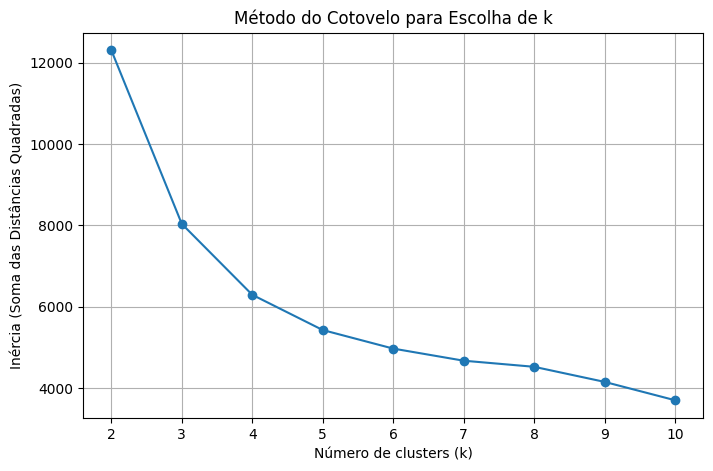

In [875]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_processed_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (Soma das Distâncias Quadradas)')
plt.title('Método do Cotovelo para Escolha de k')
plt.grid(True)
plt.show()

# Justificativa:
# A "inércia" mede quão compactos estão os clusters. O "cotovelo" indica onde a melhoria se estabiliza.


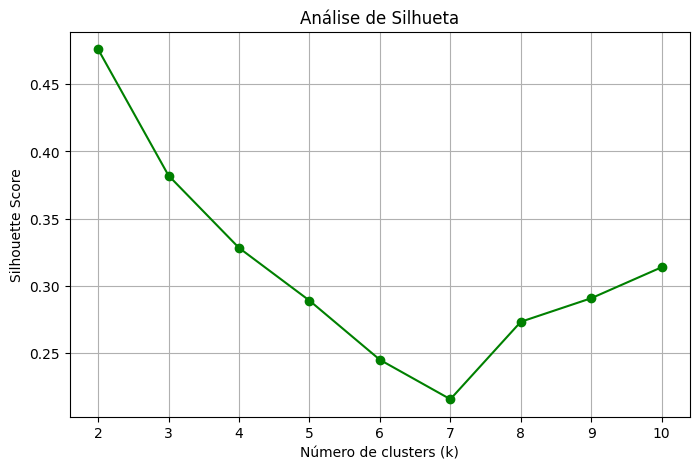

In [876]:
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_processed_scaled)
    score = silhouette_score(df_processed_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Análise de Silhueta')
plt.grid(True)
plt.show()

# Justificativa:
# O Silhouette Score varia de -1 a 1 e mede a coesão e separação dos clusters.
# Quanto mais próximo de 1, melhor os clusters estão definidos.


In [877]:
best_k = 3  # (substituir com o valor ideal após análise do gráfico)
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(df_processed_scaled)
centroids = kmeans.cluster_centers_



In [ ]:
sil_score_kmeans = silhouette_score(df_processed_scaled, labels)
db_score_kmeans = davies_bouldin_score(df_processed_scaled, labels)
ch_score_kmeans = calinski_harabasz_score(df_processed_scaled, labels)

print(f"Silhouette Score: {sil_score_kmeans:.3f}")
print(f"Davies-Bouldin Score: {db_score_kmeans:.3f}")
print(f"Calinski-Harabasz Score: {ch_score_kmeans:.3f}")

# Interpretação:
# - Silhouette: quanto maior, melhor (idealmente > 0.5)
# - Davies-Bouldin: quanto menor, melhor
# - Calinski-Harabasz: quanto maior, melhor


Silhouette Score: 0.382
Davies-Bouldin Score: 0.887
Calinski-Harabasz Score: 5706.627


C:\Users\jpedr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


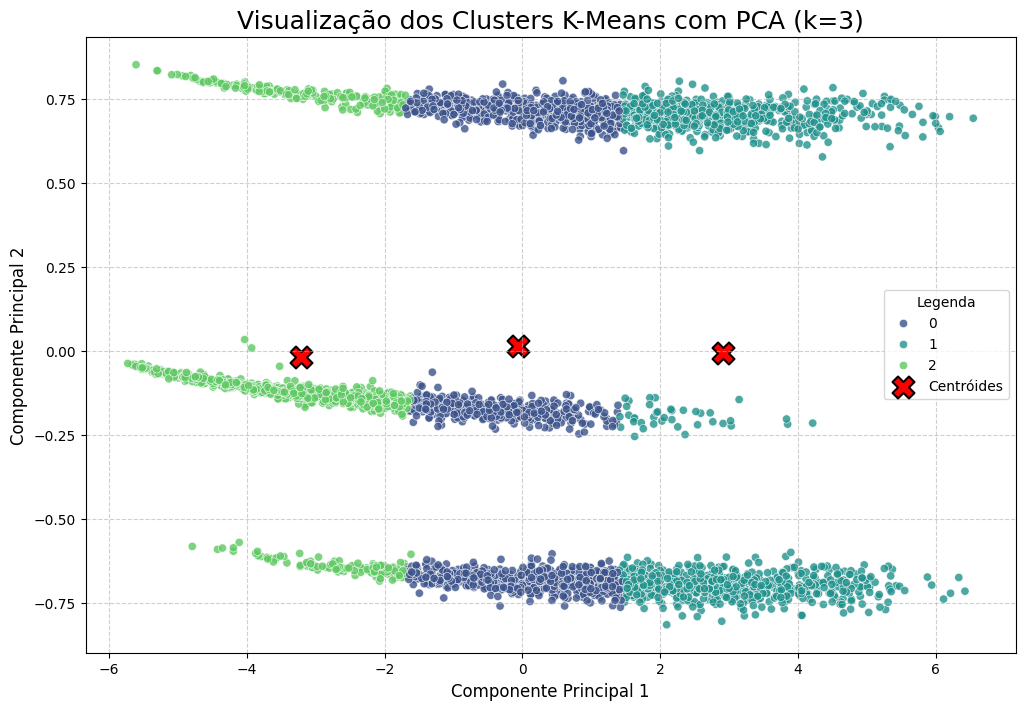

In [879]:
pca_kmeans = PCA(n_components=2, random_state=42)
coordenadas_pca = pca_kmeans.fit_transform(df_processed_scaled)

df_plot_pca = pd.DataFrame()
df_plot_pca['PCA1'] = coordenadas_pca[:, 0]
df_plot_pca['PCA2'] = coordenadas_pca[:, 1]
df_plot_pca['Cluster'] = pd.Categorical(kmeans.labels_)

plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_plot_pca,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='viridis',
    alpha=0.8,
)

centroids_pca = pca.transform(centroids)

plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker='X',
    s=250,
    c='red',
    edgecolor='black',
    linewidth=1.5,
    label='Centróides'
)

plt.title('Visualização dos Clusters K-Means com PCA (k=3)', fontsize=18)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Legenda')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Clusterização Espacial Baseada em Densidade (DBSCAN)

Vamos agrupar os dados com base na densidade, encontrando assim, clusters de formatos irregulares e identificando outliers.

Mas antes, vamos importar as bibliotecas necessárias e preparar os dados. Garantindo que vamos usar o conjunto de dados completo e aplicar o mesmo pré-processamento de escalonamento (StandardScaler) e codificação (OneHotEncoder) usado anteriormente.

## Determinando os hiperparâmetros do DBSCAN

Valor de min_samples (2 * D): 20


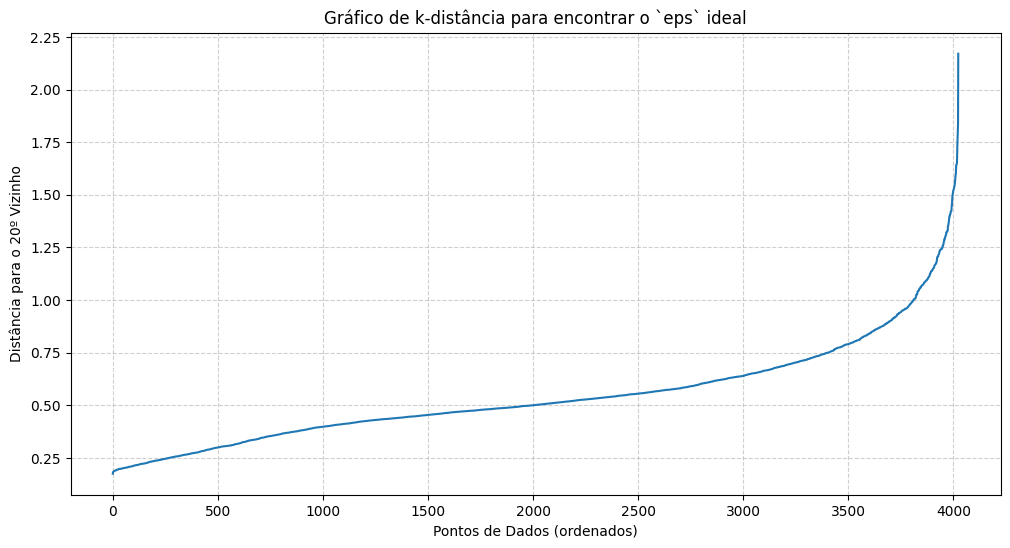

In [880]:
# 1. Definindo min_samples
D = df_processed_scaled.shape[1]
min_samples = 2*D
print(f"Valor de min_samples (2 * D): {min_samples}")

# 2. Encontrando o eps ideal com o gráfico de k-distância
k = min_samples
neighbors = NearestNeighbors(n_neighbors=k).fit(df_processed_scaled)
distances, indices = neighbors.kneighbors(df_processed_scaled)
k_distances = np.sort(distances[:, k-1], axis=0)

# Plotando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(k_distances)
plt.title('Gráfico de k-distância para encontrar o `eps` ideal')
plt.xlabel('Pontos de Dados (ordenados)')
plt.ylabel(f'Distância para o {k}º Vizinho')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [881]:
# Com base no gráfico, um valor em torno de 1.4 parece ser o ponto de cotovelo.
eps_escolhido = 1.2
print(f"\nValor de `eps` escolhido a partir do gráfico: {eps_escolhido}")


Valor de `eps` escolhido a partir do gráfico: 1.2


## Treinamento e Análise do Modelo DBSCAN

In [882]:
# Instanciando e treinando o modelo DBSCAN
dbscan = DBSCAN(eps=eps_escolhido, min_samples=min_samples)
clusters_dbscan = dbscan.fit_predict(df_processed_scaled)

# Analisando os resultados
n_clusters = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)

print(f"Número de clusters encontrados: {n_clusters}")
print(f"Número de pontos de ruído (outliers): {n_noise}")
print("\nContagem de pontos por cluster:")
print(pd.Series(clusters_dbscan).value_counts())

Número de clusters encontrados: 3
Número de pontos de ruído (outliers): 10

Contagem de pontos por cluster:
 0    1464
 2    1282
 1    1268
-1      10
Name: count, dtype: int64


## Avaliação e Visualização dos Clusters

In [883]:
core_points_mask = clusters_dbscan != -1 #Excluindo o ruído para calcular as métricas
labels_core_points = clusters_dbscan[core_points_mask]
data_core_points = df_processed_scaled[core_points_mask]

sil_score_dbscan = silhouette_score(data_core_points, labels_core_points)
db_score_dbscan = davies_bouldin_score(data_core_points, labels_core_points)
ch_score_dbscan = calinski_harabasz_score(data_core_points, labels_core_points)

print(f"\nSilhouette Score: {sil_score_dbscan:.4f}")
print(f"Davies-Bouldin Score: {db_score_dbscan:.4f}")
print(f"Calinski-Harabasz Score: {ch_score_dbscan:.2f}")


Silhouette Score: 0.1667
Davies-Bouldin Score: 2.1691
Calinski-Harabasz Score: 1167.07


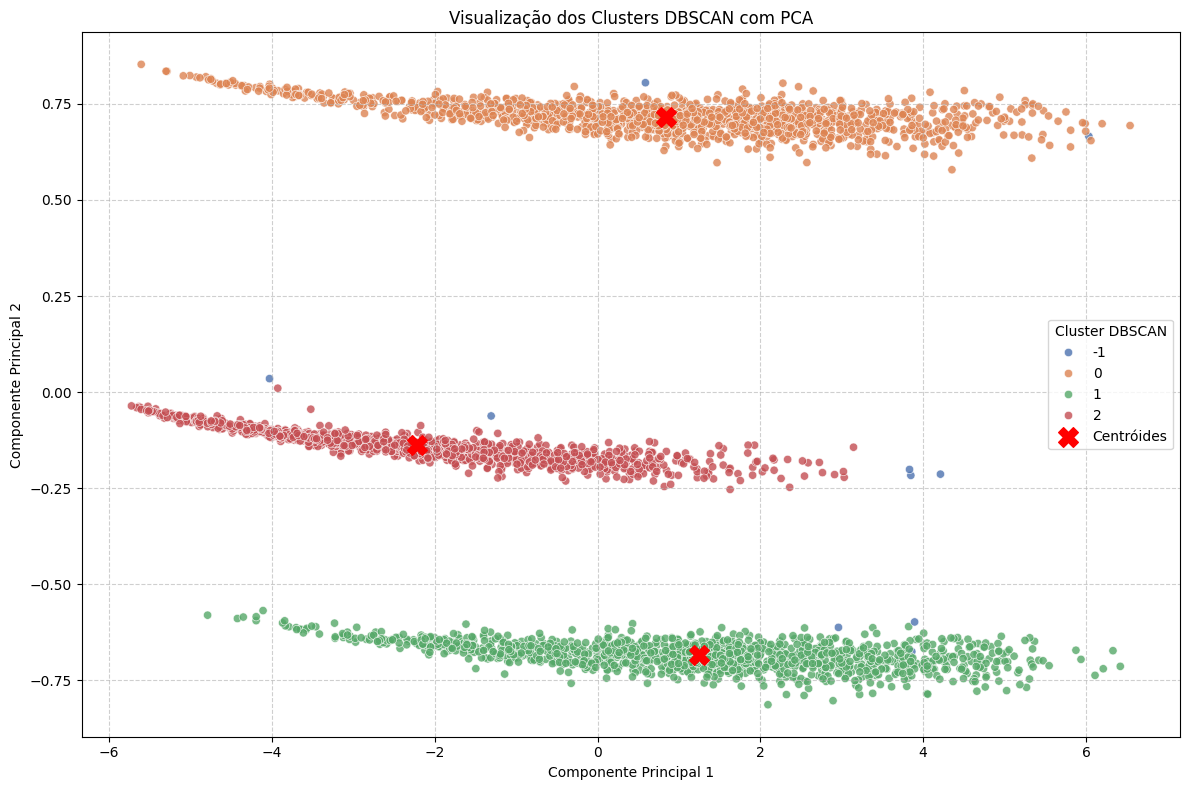

In [ ]:
# Aplica PCA
pca_DBSCAN = PCA(n_components=2)
pca_result = pca_DBSCAN.fit_transform(df_processed_scaled)

df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters_dbscan

centroids = df_pca[df_pca['Cluster'] != -1].groupby('Cluster')[['PC1', 'PC2']].mean()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=df_pca,
    palette='deep',
    alpha=0.8
)

plt.scatter(
    centroids['PC1'],
    centroids['PC2'],
    marker='X',
    s=200,
    c='red',
    label='Centróides'
)

plt.title('Visualização dos Clusters DBSCAN com PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster DBSCAN')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Clusterização Hierárquica (João Pedro)

Calculando a matriz de ligação para o dendrograma...
Cálculo concluído. Gerando o dendrograma...


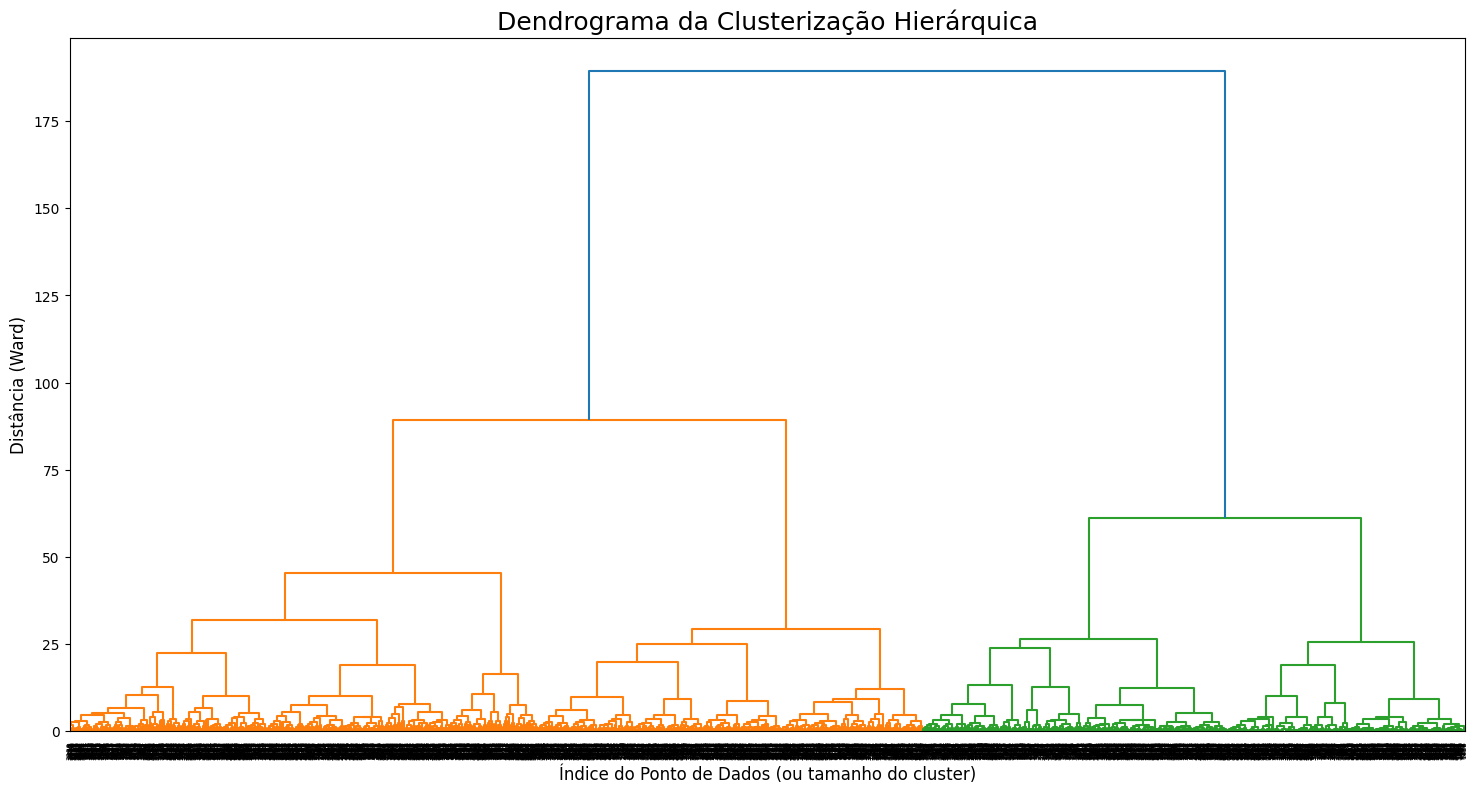

In [ ]:
linked = linkage(df_processed_scaled, method='ward')

# Plotando o dendrograma
plt.figure(figsize=(18, 9))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)

plt.title('Dendrograma da Clusterização Hierárquica', fontsize=18)
plt.xlabel('Tamanho dos Clusters', fontsize=12)
plt.ylabel('Distância', fontsize=12)
plt.show()